In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy.optimize import minimize;

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [3]:
data_train_orig = pd.read_csv('train.csv',parse_dates=['date_time'],index_col='date_time')
data_test_orig = pd.read_csv('test.csv',parse_dates=['date_time'],index_col='date_time')
sample_submission = pd.read_csv('sample_submission.csv');
target_cols = ['target_carbon_monoxide','target_benzene','target_nitrogen_oxides'];
feature_cols = list(data_test_orig.columns);

In [4]:
def munge(df):
    df['date'] = df.index.date;
    df['month'] = df.index.to_numpy().astype('datetime64[M]');
    df['month'] = df['month'].dt.month;
    df['hours'] = (df.index-pd.to_datetime('2010-03-10')) / np.timedelta64(1,'h');
    df['hour'] = df['hours'].apply(lambda h:int(h)%24);

    df['day'] = (df.index-pd.to_datetime('2010-03-10')) / np.timedelta64(1,'D');
    df['day'] = df['day'].astype(int);

    df['day_of_week'] = df.index.dayofweek;

    df['hours'] = (df.index-pd.to_datetime('2010-03-10')) / np.timedelta64(1,'h');
    df['hours'] = df['hours'].astype('float');
    
    df['bad_data'] = df['sensor_4'] < 650;
    return df;

In [5]:
data_train = data_train_orig.copy();
data_train = munge(data_train);
data_train = data_train.loc[data_train.index[~data_train['bad_data']]]

In [6]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor

transform_forward = np.log1p; transform_backward = np.expm1;

def calc_loss(ypred,y):
    errs = np.log1p(ypred) - np.log1p(y);
    return np.mean(np.sqrt(np.sum(np.power(errs,2))/len(y)));

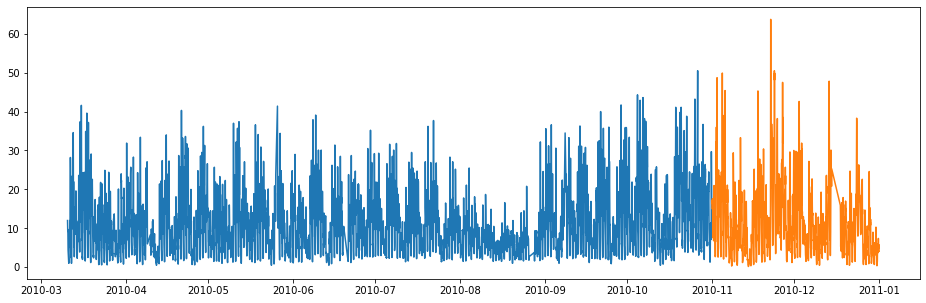

In [7]:
X_train = data_train.drop(target_cols,axis=1).select_dtypes(exclude='object');
y_train = data_train['target_benzene'];
#y_train = data_train['target_nitrogen_oxides'];
#y_train = data_train['target_carbon_monoxide'];

X_train[feature_cols] = np.log(X_train[feature_cols]);

res_train = X_train.index < '2010-11-01';
res_valid = ~res_train;

X = X_train.iloc[res_train]; y = y_train[res_train];
X_valid = X_train.iloc[res_valid]; y_valid = y_train[res_valid];

plt.figure(figsize=(16,5))
#plt.plot(X_train.index,y_train);
plt.plot(X.index,y);
plt.plot(X_valid.index,y_valid);

In [13]:
Ns = np.arange(2,50);
losses = np.zeros( (len(Ns),2) );
for jj,N in enumerate(Ns):

    myModel = LGBMRegressor(num_leaves=N);

    myModel.fit(X,transform_forward(y));
    y_pred_lgbm = transform_backward(myModel.predict(X));
    y_valid_pred_lgbm = transform_backward(myModel.predict(X_valid));

    losses[jj,0] = calc_loss(y_pred_lgbm,y);
    losses[jj,1] = calc_loss(y_valid_pred_lgbm,y_valid);

11


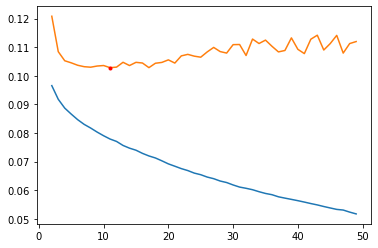

In [14]:
plt.plot(Ns,losses);

min_ind = np.argmin(losses[:,1]);
plt.plot(Ns[min_ind],losses[min_ind,1],'r.');
print(Ns[min_ind])

In [12]:
X

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,month,hours,hour,day,day_of_week,bad_data
date_time,,,,,,,,,,,,,,
2010-03-10 18:00:00,2.572612,3.828641,-0.277336,7.235043,6.991913,6.962243,7.463248,7.165030,3,18.0,18,0,2,False
2010-03-10 19:00:00,2.580217,3.813307,-0.320894,7.153912,6.789197,7.087991,7.279250,6.918596,3,19.0,19,0,2,False
2010-03-10 20:00:00,2.533697,4.028917,-0.287415,7.194362,6.834754,6.966213,7.369033,7.018402,3,20.0,20,0,2,False
2010-03-10 21:00:00,2.397895,4.133565,-0.239908,7.186144,6.834109,7.005698,7.337262,7.141403,3,21.0,21,0,2,False
2010-03-10 22:00:00,2.476538,4.077537,-0.237242,7.148346,6.748408,7.074032,7.255238,7.031918,3,22.0,22,0,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-10-31 19:00:00,3.000720,4.272491,0.558243,7.308744,7.226645,6.136863,7.553549,7.345429,10,5659.0,19,235,6,False
2010-10-31 20:00:00,2.960105,4.210645,0.542499,7.198632,7.118988,6.288787,7.535724,7.217737,10,5660.0,20,235,6,False
2010-10-31 21:00:00,3.044522,4.272491,0.528567,7.111267,7.070724,6.235195,7.580138,7.146300,10,5661.0,21,235,6,False


In [10]:
myLGBM = LGBMRegressor(num_leaves=11);

myLGBM.fit(X,transform_forward(y));
y_pred_lgbm = transform_backward(myLGBM.predict(X));
y_valid_pred_lgbm = transform_backward(myLGBM.predict(X_valid));

print('training loss   = %0.6f'%(calc_loss(y_pred_lgbm,y)))
print('validation loss = %0.6f'%(calc_loss(y_valid_pred_lgbm,y_valid)))

training loss   = 0.077881
validation loss = 0.102841


In [ ]:
transform_forward = lambda x:np.log1p(x); transform_backward = lambda x:np.expm1(x);
#transform_forward = lambda x:x; transform_backward = lambda x:x;

depths = np.arange(1,10);
losses = np.zeros( (len(depths),2) );
for jj,depth in enumerate(depths):
    
    myCat = CatBoostRegressor(learning_rate=0.01,depth=depth,logging_level='Silent');

    myCat.fit(X,transform_forward(y));
    y_pred_cat = transform_backward(myCat.predict(X));
    y_valid_pred_cat = transform_backward(myCat.predict(X_valid));

    losses[jj,0] = calc_loss(y_pred_cat,y);
    losses[jj,1] = calc_loss(y_valid_pred_cat,y_valid);
plt.plot(depths,losses);

In [ ]:
X.shape

In [ ]:
transform_forward = lambda x:np.log1p(x); transform_backward = lambda x:np.expm1(x);
#transform_forward = lambda x:x; transform_backward = lambda x:x;

etas = np.logspace(-3,-1,10);
losses = np.zeros( (len(etas),2) );
for jj,eta in enumerate(etas):
    
    myCat = CatBoostRegressor(learning_rate=eta,depth=4,logging_level='Silent');

    myCat.fit(X,transform_forward(y));
    y_pred_cat = transform_backward(myCat.predict(X));
    y_valid_pred_cat = transform_backward(myCat.predict(X_valid));

    losses[jj,0] = calc_loss(y_pred_cat,y);
    losses[jj,1] = calc_loss(y_valid_pred_cat,y_valid);

In [ ]:
plt.plot(etas,losses);
min_ind = np.argmin(losses[:,1]);
plt.plot(etas[min_ind],losses[min_ind,1],'r.');
print(etas[min_ind])

In [ ]:
myCat = CatBoostRegressor(learning_rate=0.013,depth=4,logging_level='Silent');

myCat.fit(X,transform_forward(y));
y_pred_cat = transform_backward(myCat.predict(X));
y_valid_pred_cat = transform_backward(myCat.predict(X_valid));

print('training loss   = %0.6f'%(calc_loss(y_pred_cat,y)))
print('validation loss = %0.6f'%(calc_loss(y_valid_pred_cat,y_valid)))

In [ ]:
gammas = np.linspace(.001,.4,50);
losses = np.zeros( (len(gammas),2) );

for jj,gamma in enumerate(gammas):
    myModel = XGBRegressor(gamma=gamma);

    myModel.fit(X,transform_forward(y));
    y_pred_xgb= transform_backward(myModel.predict(X));
    y_valid_pred_xgb = transform_backward(myModel.predict(X_valid));

    losses[jj,0] = calc_loss(y_pred_xgb,y);
    losses[jj,1] = calc_loss(y_valid_pred_xgb,y_valid);

In [ ]:
plt.plot(gammas,losses);

min_ind = np.argmin(losses[:,1]);
plt.plot(gammas[min_ind],losses[min_ind,1],'r.');
print(gammas[min_ind])

In [ ]:
myXGB = XGBRegressor(gamma=.066);

myXGB.fit(X,transform_forward(y));
y_pred_xgb= transform_backward(myXGB.predict(X));
y_valid_pred_xgb = transform_backward(myXGB.predict(X_valid));

print('training loss   = %0.6f'%(calc_loss(y_pred_xgb,y)))
print('validation loss = %0.6f'%(calc_loss(y_valid_pred_xgb,y_valid)))

In [ ]:
make_mix = lambda y1,y2,y3,c1,c2,c3:c1*y1 + c2*y2 + c3*y3;

loss = lambda cc:calc_loss(make_mix( y_pred_lgbm,      y_pred_cat,      y_pred_xgb,      1.-np.sum(cc),cc[0],cc[1]),y);
loss = lambda cc:calc_loss(make_mix( y_valid_pred_lgbm,y_valid_pred_cat,y_valid_pred_xgb,1.-np.sum(cc),cc[0],cc[1]),y_valid);

from scipy.optimize import minimize;
res = minimize(loss,[.2,.2]);
print(res.fun)
print(res.x)

c1 = 1.-np.sum(res.x)
c2 = res.x[0];
c3 = res.x[1];

In [ ]:
from sklearn.model_selection import KFold

N_FOLDS = 25;
myKFold = KFold(n_splits=N_FOLDS);

y_valid_pred = np.zeros( (len(X_valid),3) );

make_mix = lambda y1,y2,y3,c1,c2,c3:c1*y1 + c2*y2 + c3*y3;
make_mix = lambda y1,y2,y3,a1,a2,a3 : np.power(y1,a1) * np.power(y2,a2) * np.power(y3,a3);

for idx_fold, idx_oof in myKFold.split(X,y):
    
    X_fold = X.iloc[idx_fold]; X_oof = X.iloc[idx_oof];
    y_fold = y.iloc[idx_fold]; y_oof = y.iloc[idx_oof];

    #myCat = CatBoostRegressor(learning_rate=0.01,depth=4,logging_level='Silent');
    #myLGBM = LGBMRegressor(num_leaves=10);
    #myXGB = XGBRegressor(gamma=.05);
    
    myCat.fit(X_fold,transform_forward(y_fold));
    myLGBM.fit(X_fold,transform_forward(y_fold));
    myXGB.fit(X_fold,transform_forward(y_fold));
    
    
    
    y_fold_pred_cat  = transform_backward(myCat.predict(X_fold));
    y_fold_pred_lgbm = transform_backward(myLGBM.predict(X_fold));
    y_fold_pred_xgb  = transform_backward(myXGB.predict(X_fold));
    
    y_oof_pred_cat  = transform_backward(myCat.predict(X_oof));
    y_oof_pred_lgbm = transform_backward(myLGBM.predict(X_oof));
    y_oof_pred_xgb  = transform_backward(myXGB.predict(X_oof));
    
    y_valid_pred_cat  = transform_backward(myCat.predict(X_valid));
    y_valid_pred_lgbm = transform_backward(myLGBM.predict(X_valid));
    y_valid_pred_xgb  = transform_backward(myXGB.predict(X_valid));
    
    print('CAT  fold loss   = %0.6f  oof loss = %0.6f  valid loss = %0.6f'%( calc_loss(y_fold_pred_cat,y_fold),
                                                                             calc_loss(y_oof_pred_cat,y_oof),
                                                                             calc_loss(y_valid_pred_cat,y_valid) ));
          
    print('LGBM fold loss   = %0.6f  oof loss = %0.6f  valid loss = %0.6f'%( calc_loss(y_fold_pred_lgbm,y_fold),
                                                                             calc_loss(y_oof_pred_lgbm,y_oof),
                                                                             calc_loss(y_valid_pred_lgbm,y_valid) ));
          
    print('XGB  fold loss   = %0.6f  oof loss = %0.6f  valid loss = %0.6f'%( calc_loss(y_fold_pred_xgb,y_fold),
                                                                             calc_loss(y_oof_pred_xgb,y_oof),
                                                                             calc_loss(y_valid_pred_xgb,y_valid) ));
    
    loss = lambda cc:calc_loss(make_mix(y_oof_pred_cat,y_oof_pred_lgbm,y_oof_pred_xgb,1.-np.sum(cc),cc[0],cc[1]),y_oof);
    res = minimize(loss,[.33,.33],tol=1e-6);
    cc = res.x;
    print(cc);
    cc = [.33,.33];
    #y_valid_pred += make_mix(y_valid_pred_cat,y_valid_pred_lgbm,y_valid_pred_xgb,1.-np.sum(cc),cc[0],cc[1]) / N_FOLDS;
    
    y_valid_pred += np.vstack( (y_valid_pred_cat,y_valid_pred_lgbm,y_valid_pred_xgb) ).T / N_FOLDS;
    

In [ ]:
print(calc_loss(y_valid_pred.dot(np.array([1,0,0]).T),y_valid))
print(calc_loss(y_valid_pred.dot(np.array([0,1,0]).T),y_valid))
print(calc_loss(y_valid_pred.dot(np.array([0,0,1]).T),y_valid))

print('');

c1 = .05;
c2 = .95;
print(calc_loss(y_valid_pred.dot(np.array([1.-c1-c2,c1,c2]).T),y_valid))

In [ ]:
from sklearn.model_selection import KFold


NNs = [5,10,15,20,25,30,35];
losses = np.zeros( (len(NNs),2) );

for jj,N_FOLDS in enumerate(NNs):

    #N_FOLDS = 25;
    myKFold = KFold(n_splits=N_FOLDS);

    y_valid_pred = np.zeros( (len(X_valid)) );
    y_valid_pred_mult = np.ones( (len(X_valid)) );
    
    for idx_fold, idx_oof in myKFold.split(X,y):

        X_fold = X.iloc[idx_fold]; X_oof = X.iloc[idx_oof];
        y_fold = y.iloc[idx_fold]; y_oof = y.iloc[idx_oof];

        myXGB.fit(X_fold,transform_forward(y_fold));

        y_fold_pred_xgb  = transform_backward(myXGB.predict(X_fold));
        y_oof_pred_xgb  = transform_backward(myXGB.predict(X_oof));
        y_valid_pred_xgb  = transform_backward(myXGB.predict(X_valid));

        print('XGB  fold loss   = %0.6f  oof loss = %0.6f  valid loss = %0.6f'%( calc_loss(y_fold_pred_xgb,y_fold),
                                                                                 calc_loss(y_oof_pred_xgb,y_oof),
                                                                                 calc_loss(y_valid_pred_xgb,y_valid) ));

        y_valid_pred += y_valid_pred_xgb / N_FOLDS;
        y_valid_pred_mult *= np.power(y_valid_pred_xgb,1./N_FOLDS);
    print(calc_loss(y_valid_pred,y_valid));
    print(calc_loss(y_valid_pred_mult,y_valid));
    losses[jj,0] = calc_loss(y_valid_pred,y_valid);
    losses[jj,1] = calc_loss(y_valid_pred_mult,y_valid);

In [ ]:
plt.plot(NNs,losses)

In [ ]:
N_FOLDS = 25;
myKFold = KFold(n_splits=N_FOLDS);

#y_valid_pred = np.ones( (len(X_valid)) );
y_test_pred = np.ones( (len(X_test)) );

for idx_fold, idx_oof in myKFold.split(X_train,y_train):

    X_fold = X.iloc[idx_fold]; X_oof = X.iloc[idx_oof];
    y_fold = y.iloc[idx_fold]; y_oof = y.iloc[idx_oof];

    myXGB.fit(X_fold,transform_forward(y_fold));

    y_fold_pred_xgb  = transform_backward(myXGB.predict(X_fold));
    y_oof_pred_xgb  = transform_backward(myXGB.predict(X_oof));
    #y_valid_pred_xgb  = transform_backward(myXGB.predict(X_valid));
    y_test_pred_xgb = transform_backward(myXGB.predict(X_test));

    print('XGB  fold loss   = %0.6f  oof loss = %0.6f  valid loss = %0.6f'%( calc_loss(y_fold_pred_xgb,y_fold),
                                                                             calc_loss(y_oof_pred_xgb,y_oof),
                                                                             calc_loss(y_valid_pred_xgb,y_valid) ));

    #y_valid_pred *= np.power(y_valid_pred_xgb, 1./N_FOLDS);
    y_test_pred *= np.power(y_test_pred_xgb, 1./N_FOLDS);

In [ ]:
idx_oof.shape